Here we assume that the received signal is with residual self-intereference (i.e, SI left after passive and active cancellation).

The system we will concentrate is a SISO with node A and B.

A -----> B

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
##generate random binary data##
def generate_bitstream(size=100000):
    return np.random.choice([0, 1], size)

def db_to_numeric(SNR_dB):
    return 10 ** (SNR_dB/10)

In [3]:
size=100000
data = generate_bitstream()
print(data)

[0 0 0 ... 0 0 0]


# BPSK
First we will develop the system for BPSK modulation scheme. Due to symmetry, we will work on node A, i.e, received signal is from node B.

In [4]:
#mapping the data to BPSK signal constellation for transmission

def BPSK_symbol_mapper(ip):
    BPSK_mapped_seq = []
    for i in ip:
        if i <= 0:
            BPSK_mapped_seq.append(-1)
        else:
            BPSK_mapped_seq.append(1) 
    
    return np.array(BPSK_mapped_seq)

In [5]:
#actual data
x_b = BPSK_symbol_mapper(data)
print(x_b)

[-1 -1 -1 ... -1 -1 -1]


In [6]:
#now we have to generate the SI symbols, we will assume this to be random bitstream as well

data_SI = generate_bitstream()
x_a = BPSK_symbol_mapper(data_SI)

print(x_a)

[ 1  1  1 ... -1 -1  1]


In [7]:
#initially let us assume independent block fading (channel is quasi-static)
def rayleigh_channel_coeffs(size):
    h = np.sqrt((0.5)*(np.random.randn(size) + 1j*np.random.randn(size))) 
    return np.array(h)

In [8]:
#example
h_aa = rayleigh_channel_coeffs(1)
h_ba = rayleigh_channel_coeffs(1)

print(h_aa,h_ba)

[0.69415873-0.52766296j] [0.59448091+0.77869403j]


In [9]:
#now, noise
def AWGN(SNR,size):
    snr_lin = db_to_numeric(SNR) * 2
    n = np.sqrt(1/(2*snr_lin)) * (np.random.randn(size) + 1j*np.random.randn(size))
    return np.array(n)

In [10]:
#example
w_a = AWGN(SNR=5,size=len(x_a))
print(w_a)

[ 0.29807648-0.15552721j  0.64149585-0.05151891j -0.3859491 -0.24059302j
 ...  0.18879077+0.30794435j -0.22226013-0.37133663j
 -0.22093993-0.23757617j]


In [11]:
def received_sig(x_a,x_b,h_aa,h_bb,SNR):
    w_a = AWGN(SNR,size=len(x_a))
    y = h_aa*x_a + h_ba*x_b + w_a
    return y,h_aa,h_ba

In [12]:
#received signal will be
y_test, h_aa, h_ba = received_sig(x_a,x_b,h_aa,h_ba, SNR=5)
print(y_test)
print(h_aa, h_ba)

[ 0.15911731-1.04288188j  0.19984398-1.70496862j  0.10517192-1.07985215j
 ... -1.02129377-0.13598056j -1.00907218-0.37516789j
  0.10014321-1.29476064j]
[0.69415873-0.52766296j] [0.59448091+0.77869403j]


In [13]:
print(y_test.shape)

(100000,)


### Traditional method
The conventional channel estimation-based detection method is a technique used to detect data signals in wireless communication systems. In this method, the unknown channels are estimated first, and then the data signal is detected. The estimation of unknown channels is based on pilot signals, which are known to both the transmitter and the receiver.

**Steps:**
1. Define the modulation scheme and the transmitted data symbols.
2. Generate the pilot symbols and insert them into the transmitted signal.
3. Transmit the signal through the wireless channel.
4. Receive the signal at the receiver.
5. Extract the pilot symbols from the received signal.
6. Estimate the channel using the pilot symbols.
7. Equalize the received signal to remove the channel distortion.
8. Perform maximum likelihood (ML) detection to detect the data symbols.
9. Calculate the bit error rate (BER) of the detected data symbols.

In [14]:
num_pilot_bits = 1000

pilot_bits = generate_bitstream(size=num_pilot_bits)
pilot_symbols = BPSK_symbol_mapper(pilot_bits)

In [15]:
x_b_trad = np.concatenate((pilot_symbols,x_b))
x_a_trad = np.concatenate((pilot_symbols,x_a))

print(x_b_trad)
print(x_a_trad)

[ 1 -1  1 ... -1 -1 -1]
[ 1 -1  1 ... -1 -1  1]


In [16]:
rx_symbols, h_aa, h_ba = received_sig(x_a_trad,x_b_trad,h_aa, h_ba, SNR=5)
print(rx_symbols)

[ 1.07767157-0.00571295j -1.0743947 +0.26788927j  1.74553014+0.08770373j
 ... -1.52369025-0.75846349j -0.93589345-0.15990981j
  0.00568284-1.11642864j]


In [17]:
#extracting the pilot symbols
rx_pilot_symbols = rx_symbols[:num_pilot_bits]
rx_symbols_act = rx_symbols[num_pilot_bits:len(rx_symbols)]

#estimating the channel
h_hat = np.mean(rx_pilot_symbols / pilot_symbols)

print(h_hat)

#We see that this is very bad assumption as the channel has two different coefficients and thus it is bad choice

(1.2718425125464352+0.2562881585003787j)


In [18]:
#say we do detection using the min.distance criteria
def detection_dist(y,P=0):
    symbols = np.array([-1, 1])
    symbols_shifted = np.array([-1+P, 1+P])
    
    detected_signal = []
    
    for s in y:
        idx = np.abs(symbols_shifted - s).argmin()
        detected_signal.append(symbols[idx])
    return np.array(detected_signal)

In [19]:
#equalize the received symbols to remove channel distortion
eq_rx_symbols = rx_symbols_act / h_hat
print(eq_rx_symbols.shape)

rx_bits_detected = detection_dist(eq_rx_symbols)
print(rx_bits_detected)

(100000,)
[-1  1 -1 ... -1 -1 -1]


In [20]:
def estimate_error_prob(y,y_detected):
    errors = 0
    
    y, y_detected = np.array(y), np.array(y_detected)
    tmp = zip(y, y_detected)
    
    for i,j in tmp:
        if (i) != (j):
            errors += 1
            
    return errors/len(y)

In [21]:
prob_error_test = estimate_error_prob(x_b, rx_bits_detected)
print(prob_error_test)

0.14222


In [22]:
SNR_db = np.arange(-5,11)

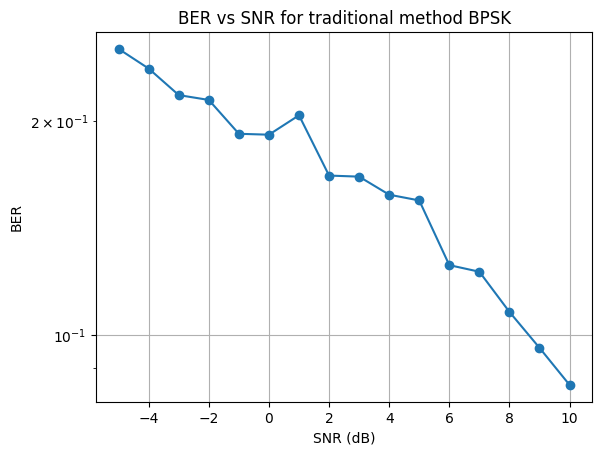

In [38]:
BER_trad = []

for s in SNR_db:
    rx_symbols, h_aa, h_ba = received_sig(x_a_trad,x_b_trad,h_aa,h_ba, s)
    rx_pilot_symbols = rx_symbols[:num_pilot_bits]
    rx_symbols_act = rx_symbols[num_pilot_bits : len(rx_symbols)]

    h_hat = np.mean(rx_pilot_symbols / pilot_symbols)
    eq_rx_symbols = rx_symbols_act / h_hat
    
    rx_bits_detected = detection_dist(eq_rx_symbols)
    prob = estimate_error_prob(x_b, rx_bits_detected)
    BER_trad.append(prob)
    
# Plot BER vs SNR
plt.semilogy(SNR_db, BER_trad, 'o-')
plt.title("BER vs SNR for traditional method BPSK")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()

In [39]:
#we observe that this is veryyy bad so we can use two pilot systems to increase the efficiency of calulating the h
#say we take two different pilot_symbols => Px_a[0] and [0]x_bP
# y = h_aa*(Px_a[0]) + h_ba*([0]x_bP) + w_a

x_b_trad_2 = np.concatenate((np.zeros_like(pilot_symbols),x_b,pilot_symbols))
x_a_trad_2 = np.concatenate((pilot_symbols,x_a,np.zeros_like(pilot_symbols)))

print(x_b_trad_2.shape)

(102000,)


In [40]:
rx_symbols, h_aa, h_ba = received_sig(x_a_trad_2,x_b_trad_2,h_aa,h_ba,5)

rx_pilot_symbols_1 = rx_symbols[:num_pilot_bits]
rx_symbols_act = rx_symbols[num_pilot_bits : len(rx_symbols)-num_pilot_bits]
rx_pilot_symbols_2 = rx_symbols[len(rx_symbols)-num_pilot_bits : len(rx_symbols)]

h_aa_hat = np.mean(rx_pilot_symbols_1 / pilot_symbols)
h_ba_hat = np.mean(rx_pilot_symbols_2 / pilot_symbols)

print(h_aa_hat, h_ba_hat)
print(h_aa, h_ba)

(0.6982017695399885-0.5262055316876398j) (0.5877210391276886+0.7753531179075445j)
[0.69415873-0.52766296j] [0.59448091+0.77869403j]


In [41]:
#as we are operating on node A, we know x_a
#y = h_aa*(x_a) + h_ba*(x_b) + w_a
#thus for equalization, y_eq = y/h_ba = x_b + (h_aa/h_ba)*x_a + w_a/h_ba
#to furthur increase our detection efficiency we can find y_eq = x_b + w_a/h_ba

eq_rx_symbols_2 = (rx_symbols_act/h_ba_hat) - (h_aa_hat/h_ba_hat)*x_a
rx_bits_detected_2 = detection_dist(eq_rx_symbols_2)

prob_error_test_2 = estimate_error_prob(x_b, rx_bits_detected_2)
print(prob_error_test_2)

0.00026


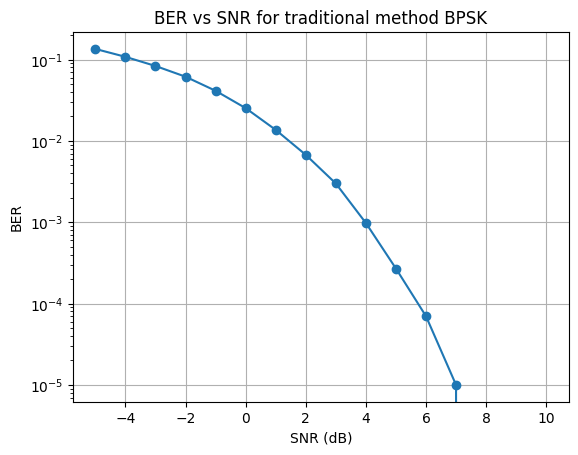

In [42]:
BER_trad_2 = []

for s in SNR_db:
    rx_symbols, h_aa, h_ba = received_sig(x_a_trad_2,x_b_trad_2,h_aa,h_ba,s)
    
    rx_pilot_symbols_1 = rx_symbols[:num_pilot_bits]
    rx_symbols_act = rx_symbols[num_pilot_bits : len(rx_symbols)-num_pilot_bits]
    rx_pilot_symbols_2 = rx_symbols[len(rx_symbols)-num_pilot_bits : len(rx_symbols)]

    h_aa_hat = np.mean(rx_pilot_symbols_1 / pilot_symbols)
    h_ba_hat = np.mean(rx_pilot_symbols_2 / pilot_symbols)
    
    eq_rx_symbols_2 = (rx_symbols_act/h_ba_hat) - (h_aa_hat/h_ba_hat)*x_a
    rx_bits_detected_2 = detection_dist(eq_rx_symbols_2)

    prob_error_test_2 = estimate_error_prob(x_b, rx_bits_detected_2)
    BER_trad_2.append(prob_error_test_2)
    
# Plot BER vs SNR
plt.semilogy(SNR_db, BER_trad_2, 'o-')
plt.title("BER vs SNR for traditional method BPSK")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()

We observed that one way to way to make a reliable communication is to use pilots (to estimate channel). In this project, we will tackle this problem without using the channel estimates. We will use a method called **Superimposed Signalling**.

### SuperImposed Signalling

In [28]:
#first we will make the marginal probability distribution

As we are assuming the channel to be quasi-static, we can consider the integrals involving channel estimates to be constant. 

In [43]:
P = 1

rx_data,_, _ = received_sig(x_a+P,x_b+P,h_aa,h_ba,5)
tx_data = x_b+P

In [44]:
# Define MAP detection function
def marginal_pdf(y, alpha, SNR, P=0):
    snr_lin = db_to_numeric(SNR) * 2
    sigma_sq = 1/snr_lin
    
    symbols = [-1+P,1+P]
    
    # Compute prior probabilities
    p_s_0 = 1 - alpha
    p_s_1 = alpha

    # Compute likelihood probabilities
    y = np.real(y)
    p_y_given_s_0 = np.exp(-(y - symbols[0])**2 / (2 * sigma_sq)) / np.sqrt(2 * np.pi * sigma_sq)
    p_y_given_s_1 = np.exp(-(y - symbols[1])**2 / (2 * sigma_sq)) / np.sqrt(2 * np.pi * sigma_sq)

    #calculating probabilty of y=0 and y=1 from the data
    #y_init_guess = np.real(y)
    #detection_dig = np.mean(symbols)
    #num_1s = y_init_guess[y_init_guess>detection_dig].shape[0]
    #p_y_1 = num_1s/(100000)
    #p_y_0 = 1 - p_y_1
    
    #p_s_given_y_0 = p_s_0 * p_y_given_s_0 / p_y_0
    #p_s_given_y_1 = p_s_1 * p_y_given_s_1 / p_y_1
    
    # Compute posterior probabilities
    p_s_given_y_0 = p_s_0 * p_y_given_s_0
    p_s_given_y_1 = p_s_1 * p_y_given_s_1
    
    #Normalizing the probabilities
    p_s_given_y_0 = p_s_given_y_0 / (p_s_given_y_0 + p_s_given_y_1)
    p_s_given_y_1 = 1 - p_s_given_y_0
    
    return p_s_given_y_0, p_s_given_y_1

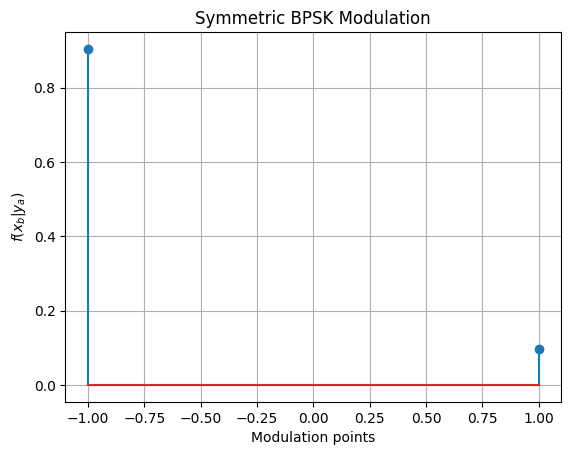

1.0


In [45]:
y_test, _, _ = received_sig(x_a,x_b,h_aa,h_ba,5)
x, y = marginal_pdf(y_test[1],0.5,5)

plt.stem((-1,1),(x,y))
plt.ylabel("$f(x_{b}|y_{a})$")
plt.xlabel("Modulation points")
plt.title("Symmetric BPSK Modulation")
plt.grid()
plt.show()

print(x+y)

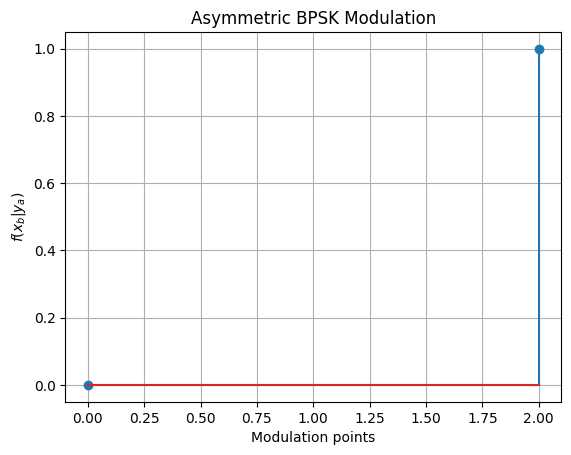

In [46]:
x, y = marginal_pdf(rx_data[1],0.5,5,P)

plt.stem((-1+P,1+P),(x,y))
plt.ylabel("$f(x_{b}|y_{a})$")
plt.xlabel("Modulation points")
plt.title("Asymmetric BPSK Modulation")
plt.grid()
plt.show()

In [47]:
def detected_sig_mpdf(rx_data,alpha,SNR,P=0):
    op = np.zeros_like(rx_data)
    symbols = [-1+P, 1+P]
    
    for i in range(rx_data.shape[0]):
        x, y = marginal_pdf(rx_data[i],alpha,SNR,P)
        
        if x <= y:
            op[i] = symbols[1]
        else:
            op[i] = symbols[0]
    return np.real((op))

In [48]:
op = detected_sig_mpdf(y_test,0.5,5)
err = estimate_error_prob(x_b, op)

print(err)

0.31927


In [49]:
op = detected_sig_mpdf(rx_data,0.5,5,P)
err = estimate_error_prob(tx_data, op)

print(err)

0.29134


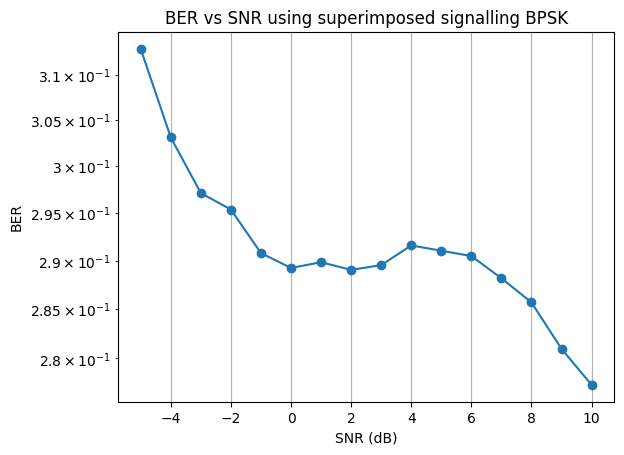

In [50]:
BER_sp = []

for s in SNR_db:
    rx_data,h_aa, h_ba = received_sig(x_a+P,x_b+P,h_aa,h_ba,s)
    tx_data = x_b+P
    
    op = detected_sig_mpdf(rx_data,0.5,s,P)
    err = estimate_error_prob(tx_data, op)
    
    BER_sp.append(err)
    
# Plot BER vs SNR
plt.semilogy(SNR_db, BER_sp, 'o-')
plt.title("BER vs SNR using superimposed signalling BPSK")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()

In [51]:
tmp1 = np.zeros_like(BER_sp)
for i in range(5):
    print("iteration -> ", i)
    for i,s in enumerate(SNR_db):
        print("  snr -> ",s)
        tmp2 = 0
        rx_data,h_aa, h_ba = received_sig(x_a+P,x_b+P,h_aa,h_ba,s)
        tx_data = x_b+P

        op = detected_sig_mpdf(rx_data,0.5,s,P)
        tmp2 = estimate_error_prob(tx_data, op)
        tmp1[i] += tmp2

#err = err/10

iteration ->  0
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  1
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  2
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  3
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  4
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  s

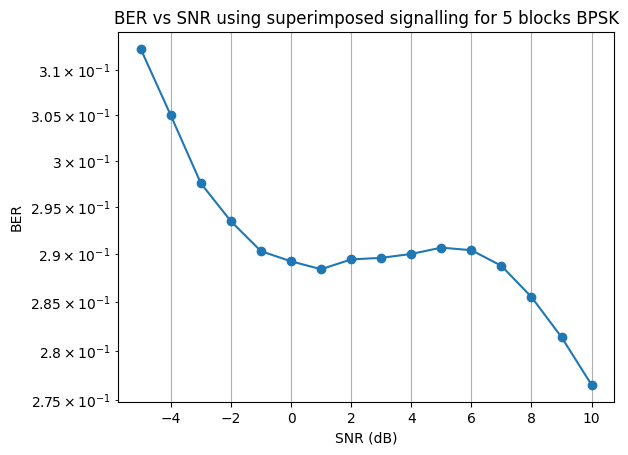

In [52]:
BER_sp_2 = tmp1/5

# Plot BER vs SNR
plt.semilogy(SNR_db, BER_sp_2, 'o-')
plt.title("BER vs SNR using superimposed signalling for 5 blocks BPSK")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()

# RIS

In [53]:
def multipaths(y):
    angles = [30, 45, 60, 75, 90, 105, 120,150]
    outputs = []
    for angle in angles:
        if(angle == 30):
               y_new = 1.2*np.array(y)
        elif(angle == 60):
                y_new = 1*np.array(y)
        elif(angle == 90):
            y_new = 0.8*np.array(y)
        elif(angle == 120):
            y_new = 0.6*np.array(y)
        else:
            y_new = 0
        outputs.append([angle, y_new])
    return outputs

### Now integrating RIS with superimposed signalling

In [54]:
#let this signal rx_data we used for the previous analysing. Let this recieved signal be the received signal at the RIS
#Let this signal be arriving with different paths (due to scattering and reflection) with different angles. We will use RIS 
# to select y with only certain angles and reject the others
# the selected signals are reflected with angles such that they reach the Tx at node B with better efficiency and amplitude

#testing
rx_data,h_aa, h_ba = received_sig(x_a+P,x_b+P,h_aa,h_ba,5)
tx_data = x_b+P

rx_multipaths = multipaths(rx_data)

angles = []
values = []

for tmp in rx_multipaths:
    angles.append(np.array(tmp[0]))
    values.append(np.array(tmp[1]))
    
values = np.array(values)    
#print(values.shape)

#rx_RIS = np.sqrt(values[0]**2 + values[1]**2+values[2]**2 + values[3]**2 +values[4]**2 +values[5]**2 + values[6]**2+values[7]**2)
#rx_RIS = (values[0]+ values[1] +values[2] + values[3] +values[4] +values[5] + values[6]+values[7])
#rx_RIS = np.max((values[0], values[1],values[2], values[3],values[4],values[5], values[6],values[7]))

rx_RIS = np.zeros_like(rx_data)
for i in range(rx_data.shape[0]):
    rx_RIS[i] = max(np.array(values[0][i]),np.array(values[2][i]),np.array(values[4][i]),np.array(values[6][i]))
    #rx_RIS[i] = max(np.array(values[0][i]),np.array(values[1][i]),np.array(values[2][i]),np.array(values[3][i]),
     #               np.array(values[4][i]),np.array(values[5][i]),np.array(values[6][i]),np.array(values[7][i]),)
    
print(rx_RIS)

/tmp/ipykernel_39243/3954718838.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(values)


[2.17715895-1.35972555j 2.34697732-1.43879212j 1.49137163-1.36829048j ...
 0.22982785-0.54774777j 0.04917401-0.28443416j 1.24536567-1.03032481j]


In [55]:
#Now we will use superimposed signalling for this recieved output at the receiver
op = detected_sig_mpdf(rx_RIS,0.5,5,P)
err = estimate_error_prob(tx_data, op)

print(err)

0.26917


In [56]:
BER_sp_RIS = []

for s in SNR_db:
    P = 1
    rx_data,h_aa, h_ba = received_sig(x_a+P,x_b+P,h_aa,h_ba,s)
    tx_data = x_b+P
    
    rx_multipaths = multipaths(rx_data)

    angles = []
    values = []

    for tmp in rx_multipaths:
        angles.append(tmp[0])
        values.append(tmp[1])

    #rx_RIS = (values[0]+ values[1] +values[2] + values[3] +values[4] +values[5] + values[6]+values[7])
    #rx_RIS = (values[0]+ values[1] +values[2] + values[3] +values[4] +values[5] + values[6]+values[7])/8
    #rx_node_b = received_sig_b(rx_RIS, s)
    
    #rx_RIS = np.zeros_like(rx_data)
    for i in range(rx_data.shape[0]):
        rx_RIS[i] = max((values[0][i]),(values[2][i]),(values[4][i]),(values[6][i]))
    
    
    op = detected_sig_mpdf(rx_RIS,0.5,s,P)
    err = estimate_error_prob(tx_data, op)
    
    BER_sp_RIS.append(err)

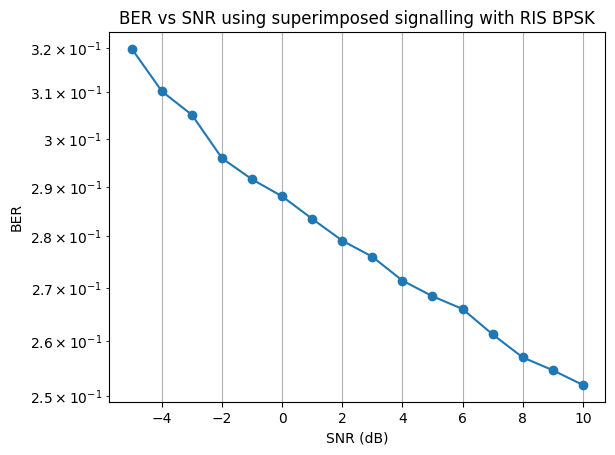

In [57]:
# Plot BER vs SNR
plt.semilogy(SNR_db, BER_sp_RIS, 'o-')
plt.title("BER vs SNR using superimposed signalling with RIS BPSK")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()

In [58]:
tmp1 = np.zeros_like(BER_sp_RIS)
for x in range(5):
    print("iteration -> ", x)
    
    for i,s in enumerate(SNR_db):
        print("  snr -> ",s)
        
        tmp2 = 0
        
        rx_data,h_aa, h_ba = received_sig(x_a+P,x_b+P,h_aa,h_ba,s)
        tx_data = x_b+P

        rx_multipaths = multipaths(rx_data)

        angles = []
        values = []

        for tmp in rx_multipaths:
            angles.append(tmp[0])
            values.append(tmp[1])

        #rx_RIS = (values[0]+ values[1] +values[2] + values[3] +values[4] +values[5] + values[6]+values[7])
        #rx_node_b = received_sig_b(rx_RIS, s)
        
        rx_RIS = np.zeros_like(rx_data)
        
        for j in range(rx_data.shape[0]):
            rx_RIS[j] = max(np.array(values[0][j]),np.array(values[2][j]),np.array(values[4][j]),np.array(values[6][j]))

        op = detected_sig_mpdf(rx_RIS,0.5,s,P)
        tmp2 = estimate_error_prob(tx_data, op)
    
        tmp1[i] += tmp2

#err = err/10

iteration ->  0
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  1
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  2
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  3
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  snr ->  5
  snr ->  6
  snr ->  7
  snr ->  8
  snr ->  9
  snr ->  10
iteration ->  4
  snr ->  -5
  snr ->  -4
  snr ->  -3
  snr ->  -2
  snr ->  -1
  snr ->  0
  snr ->  1
  snr ->  2
  snr ->  3
  snr ->  4
  s

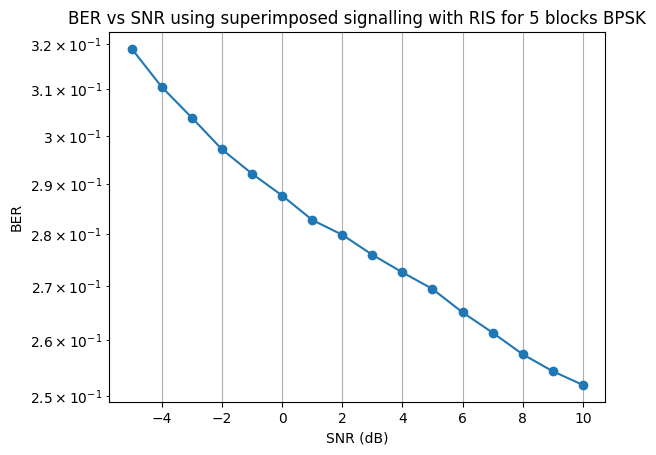

In [59]:
BER_sp_RIS_2 = tmp1/5

# Plot BER vs SNR
plt.semilogy(SNR_db, BER_sp_RIS_2, 'o-')
plt.title("BER vs SNR using superimposed signalling with RIS for 5 blocks BPSK")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()

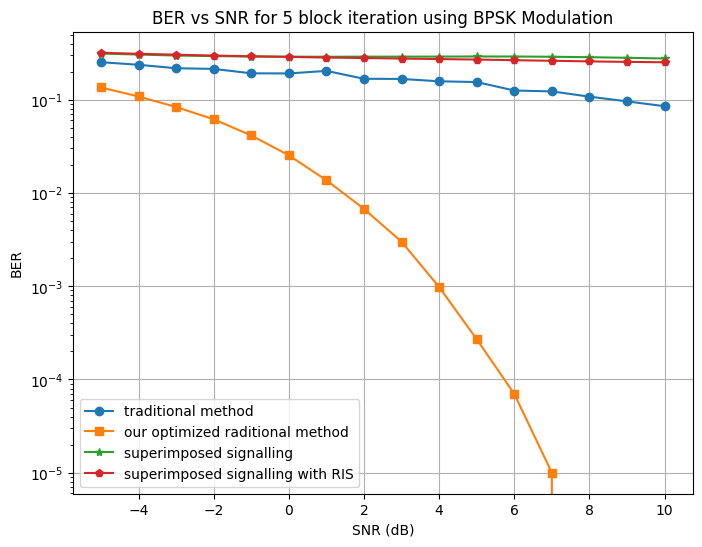

In [60]:
#plotting all the BER in one plot
plt.figure(figsize=(8,6))
plt.semilogy(SNR_db, BER_trad, 'o-', label = "traditional method")
plt.semilogy(SNR_db, BER_trad_2, 's-', label ="our optimized raditional method")
plt.semilogy(SNR_db, BER_sp_2, '*-', label = "superimposed signalling")
plt.semilogy(SNR_db, BER_sp_RIS_2, 'p-', label = "superimposed signalling with RIS")
plt.title("BER vs SNR for 5 block iteration using BPSK Modulation")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()
plt.grid(True)
plt.show()